In [1]:

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('retina')  
plt.rcParams['figure.figsize'] = (14, 6)   
plt.rcParams['figure.dpi'] = 120          
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']



In [2]:
import pandas as pd
import numpy as np

bookings_path = "../data/processed_sports_facilities_11.csv"
facilities_path = "../data/sport_facilities.csv"

df_book = pd.read_csv(bookings_path)
df_fac = pd.read_csv(facilities_path)
df = pd.merge(df_book, df_fac, left_on="placeCode", right_on="place_code", how="left")

df["bookingDate_dt"] = pd.to_datetime(df["bookingDate"], errors="coerce", utc=True)
df["month"] = df["bookingDate_dt"].dt.month

def classify_sport(desc):
    if not isinstance(desc, str):
        return "Other"
    s = desc.lower()
    if "table tennis" in s:
        return "Table Tennis"
    if "tennis" in s:
        return "Tennis"
    if "badminton" in s:
        return "Badminton"
    if "basketball" in s:
        return "Basketball"
    if "swimming" in s or "pool" in s:
        return "Swimming"
    return "Other"

df["sport"] = df["description"].apply(classify_sport)
tennis_df = df[df["sport"] == "Tennis"].copy()


/var/folders/fq/3pmzyx3s60l0sjm0lfcpdfhh0000gn/T/ipykernel_30856/959101953.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily, x="weekday", y="occupied_count", order=order, palette="YlGnBu", showfliers=False)


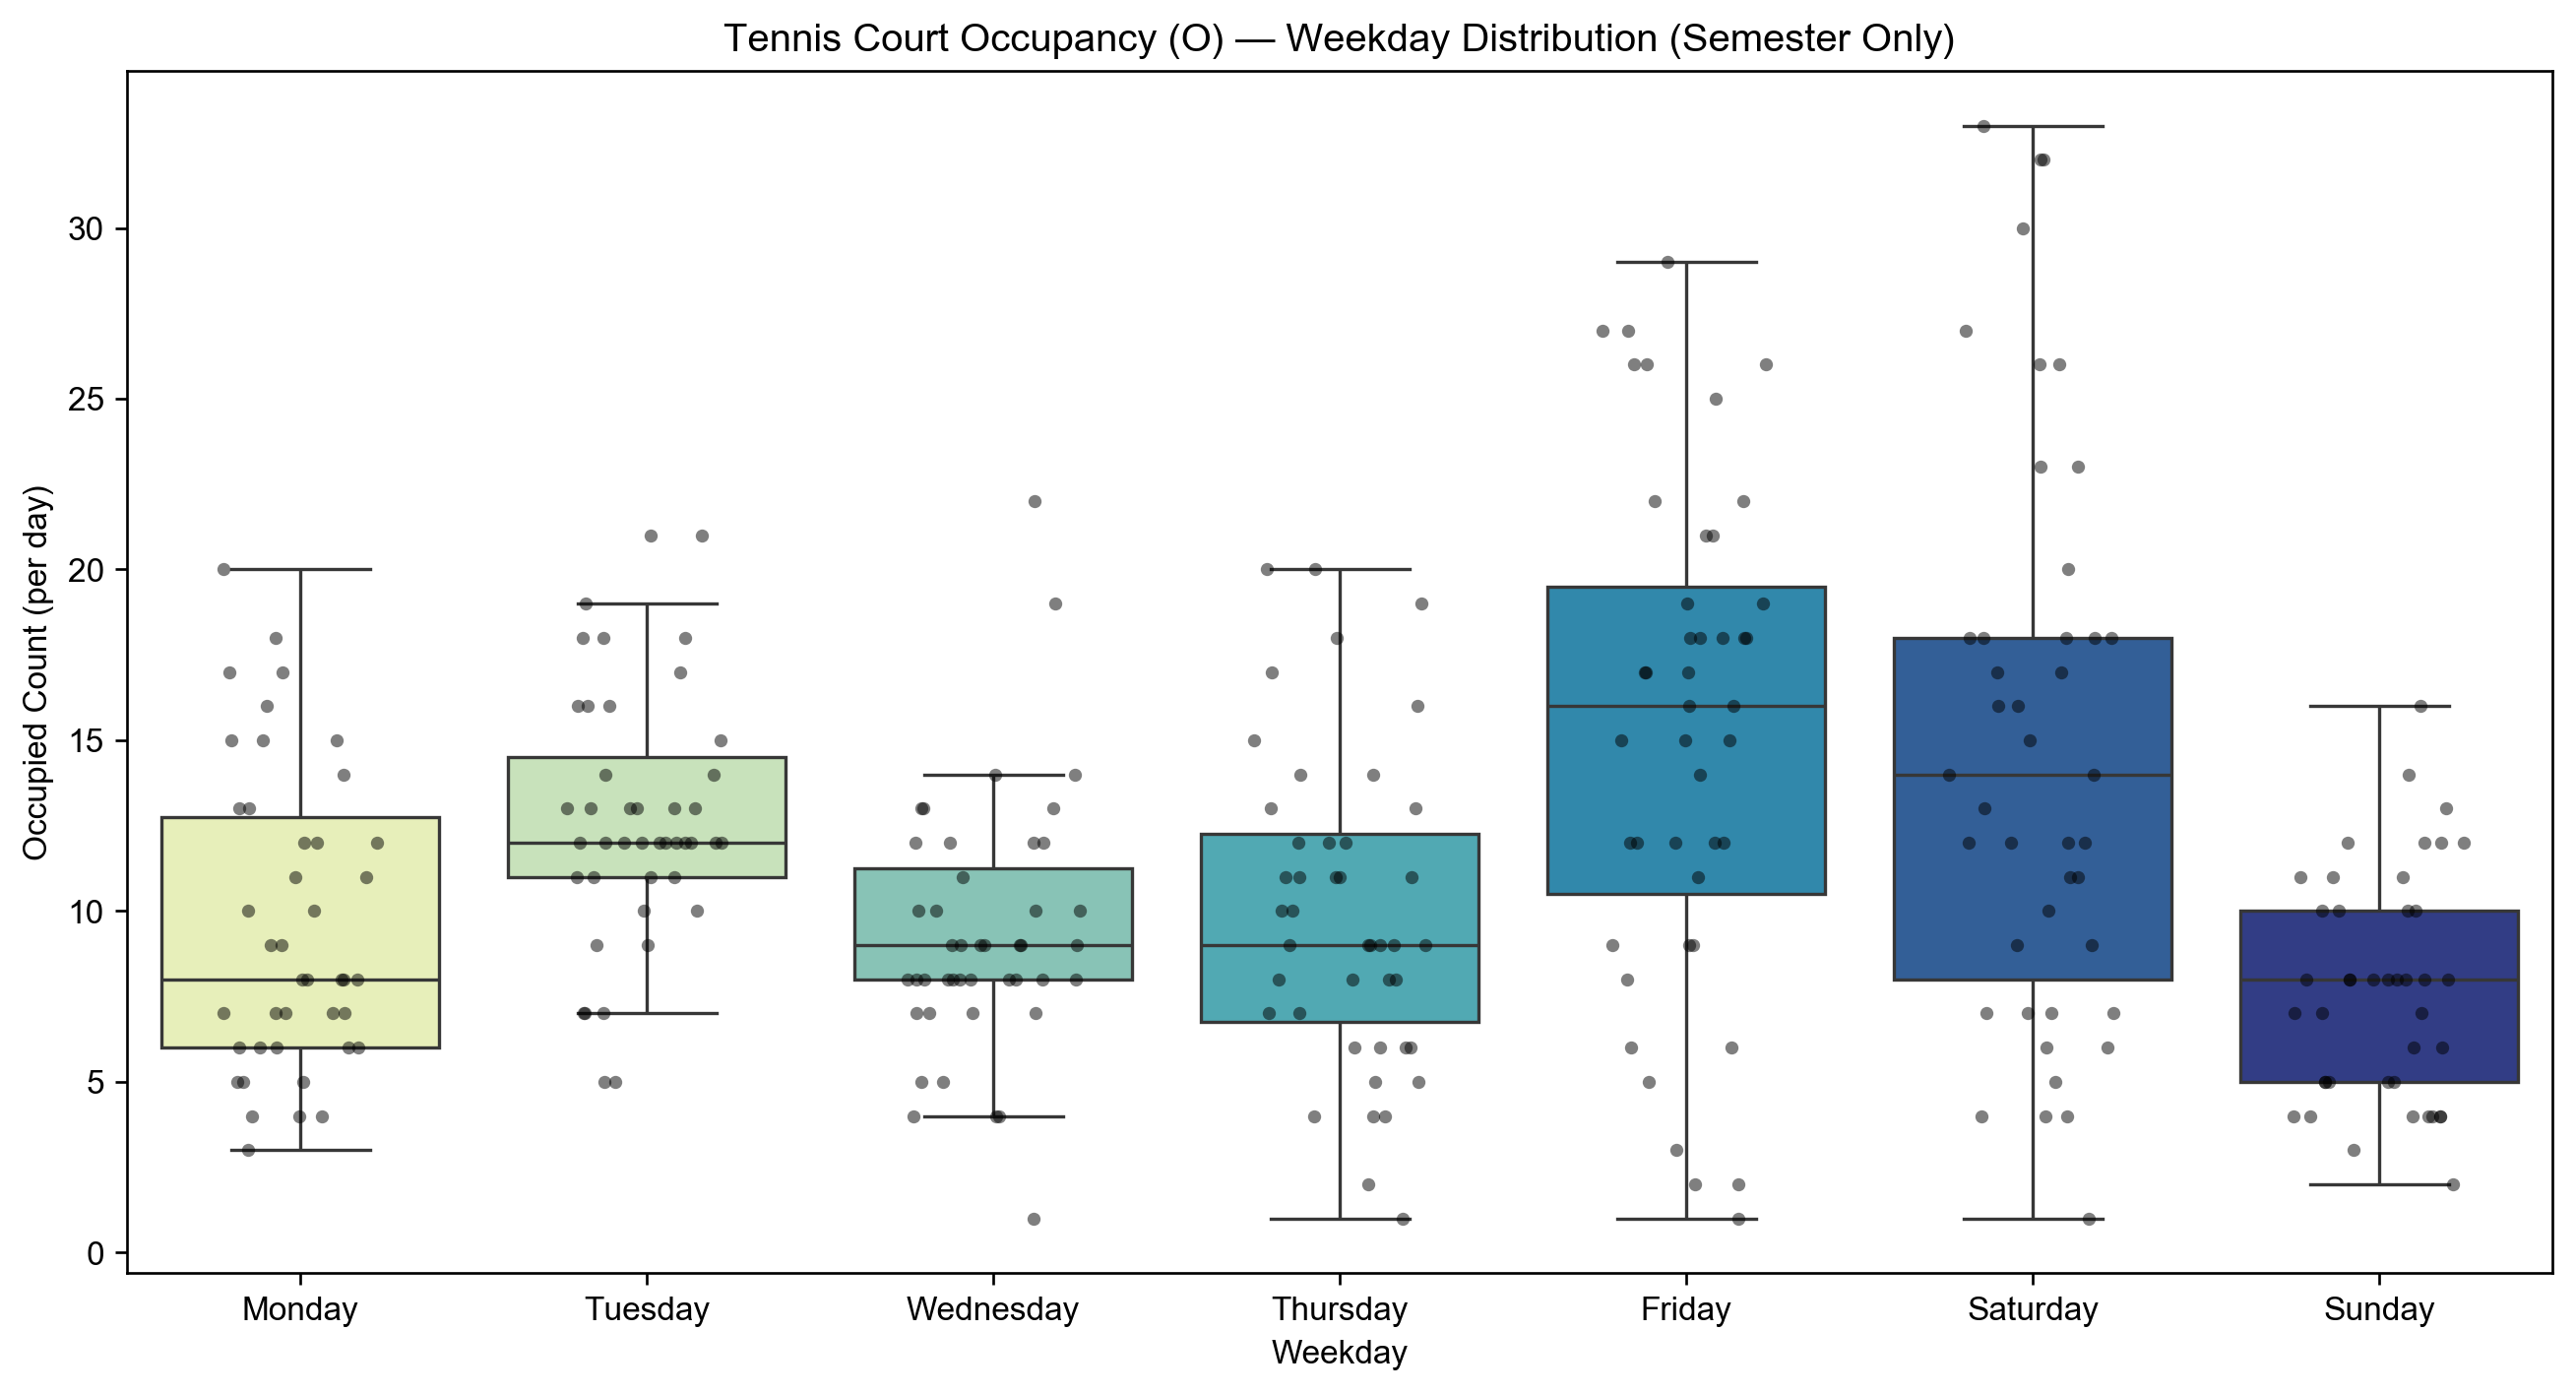

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = tennis_df[tennis_df["bookingStatus"] == "O"].copy()
df["dt"] = pd.to_datetime(df["bookingDate_dt"])
df["date"] = df["dt"].dt.date
df["month"] = df["dt"].dt.month
df["weekday"] = df["dt"].dt.day_name()


semester_df = df[
    ((df["month"] >= 2) & (df["month"] <= 6)) |
    ((df["month"] >= 8) & (df["month"] <= 12))
].copy()


daily = semester_df.groupby(["date", "weekday"])["placeCode"].count().reset_index(name="occupied_count")


order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]


plt.figure(figsize=(11,6))
sns.boxplot(data=daily, x="weekday", y="occupied_count", order=order, palette="YlGnBu", showfliers=False)
sns.stripplot(data=daily, x="weekday", y="occupied_count", order=order, color="black", size=4, jitter=0.25, alpha=0.5)
plt.title("Tennis Court Occupancy (O) — Weekday Distribution (Semester Only)")
plt.xlabel("Weekday")
plt.ylabel("Occupied Count (per day)")
plt.tight_layout()
plt.show()


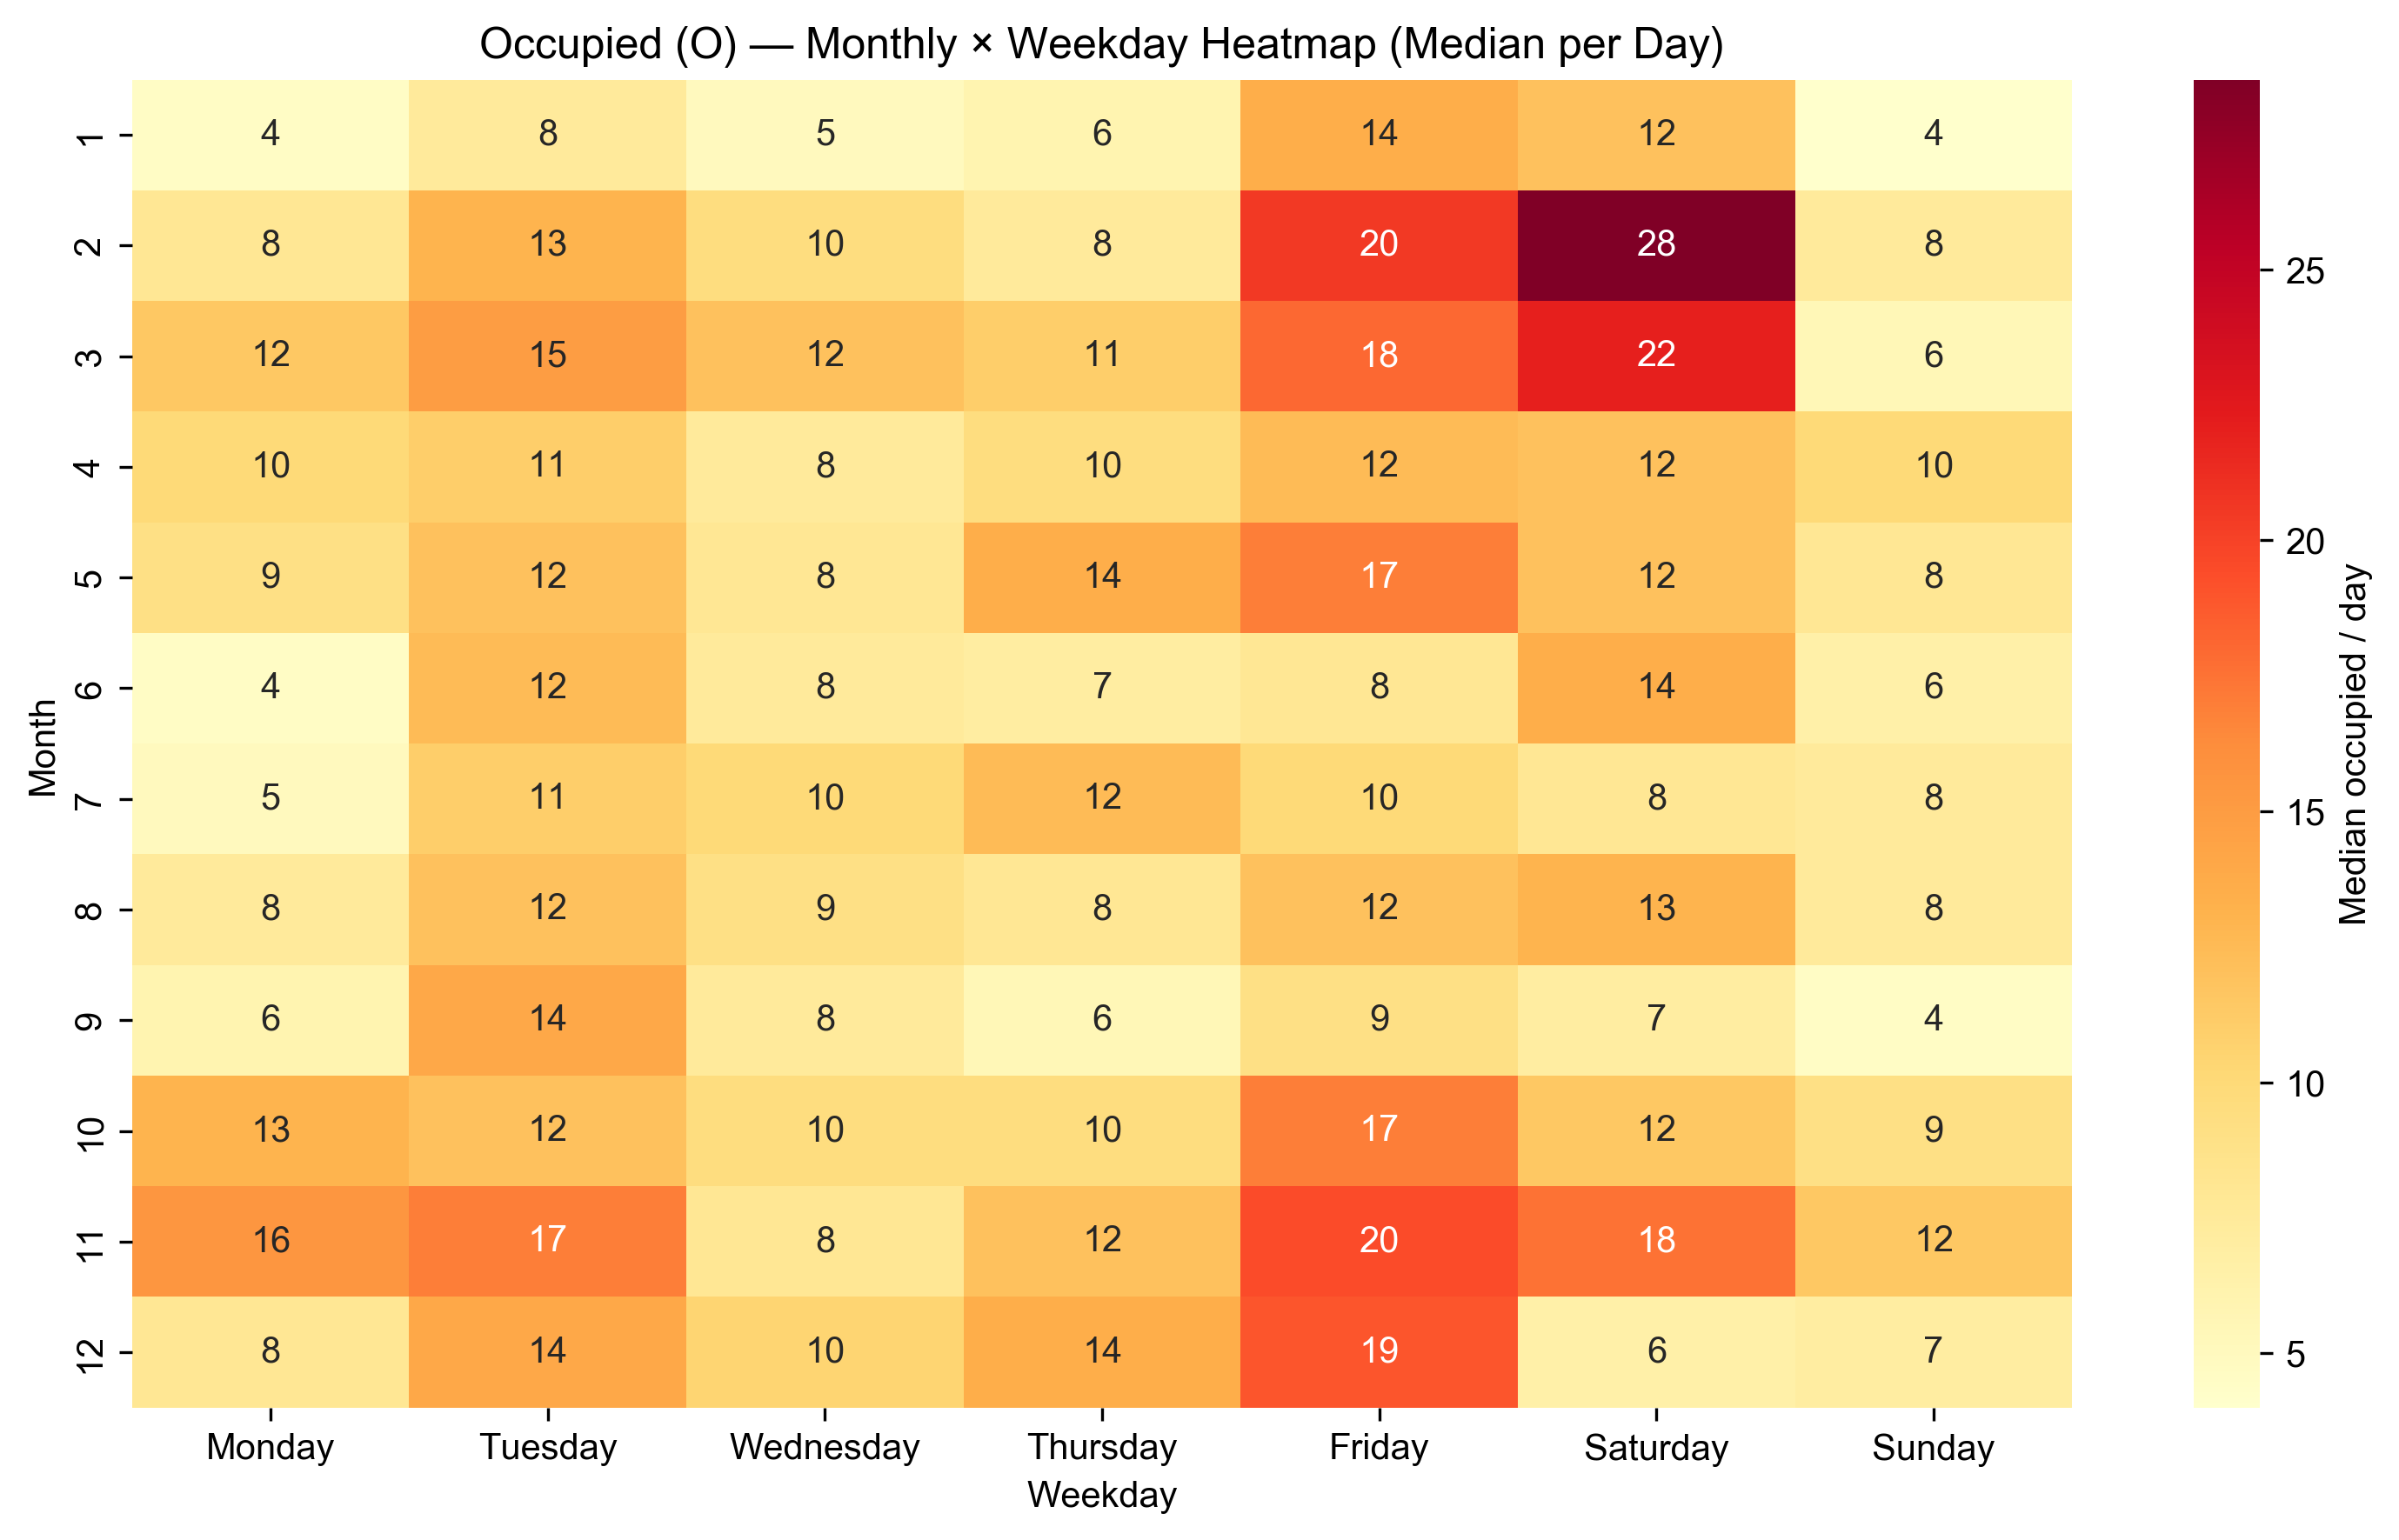

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


o = tennis_df[tennis_df["bookingStatus"] == "O"].copy()
o["dt"] = pd.to_datetime(o["bookingDate_dt"], errors="coerce", utc=True)
o["month"] = o["dt"].dt.month
o["weekday"] = o["dt"].dt.day_name()   # 'Monday' ... 'Sunday'
ordered_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]


per_day = (
    o.groupby(o["dt"].dt.date)["placeCode"]
      .count()
      .reset_index(name="occupied_count")
)

# 2. Rename the grouping key column to date
per_day = per_day.rename(columns={"dt": "date"})  # If this column has a different name, replace "dt" with the actual column name
per_day["date"] = pd.to_datetime(per_day["date"], errors="coerce")

# 3. Extract month and weekday again
per_day["month"] = per_day["date"].dt.month
per_day["weekday"] = per_day["date"].dt.day_name()

# 4. Make a median pivot table
pivot_med = (
    per_day.groupby(["month", "weekday"])["occupied_count"]
           .median()
           .reset_index(name="median_per_day")
           .pivot(index="month", columns="weekday", values="median_per_day")
           .reindex(index=range(1, 13), columns=ordered_days)
)


plt.figure(figsize=(10,6), dpi=150)
sns.heatmap(pivot_med, cmap="YlOrRd", annot=True, fmt=".0f",
            cbar_kws={"label":"Median occupied / day"})
plt.title("Occupied (O) — Monthly × Weekday Heatmap (Median per Day)")
plt.xlabel("Weekday"); plt.ylabel("Month")
plt.tight_layout()
plt.show()